In [1]:
# only adjust settings in this cell
state = 'ME' 
year = 2020
enumeration_limit = 10

In [2]:
import sys, os
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [3]:
filepath = '../../dat/' + str(year) + '/'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [4]:
from read import read_graph_from_json
import networkx as nx

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of ME has 2 districts.


In [5]:
from optimization import generate_plans_with_refinement

plans, first_feasible_dev = generate_plans_with_refinement(G, ideal_population, state, year, enumeration_limit)


*****************************************
Trying deviation = 0.5.
*****************************************
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
Total time = 0.13

*****************************************
Trying deviation = 1.0.
*****************************************
Total time = 0.0

*****************************************
Trying deviation = 2.0.
*****************************************
Total time = 0.12

*****************************************
Trying deviation = 4.0.
*****************************************
Total time = 0.11

*****************************************
Trying deviation = 8.0.
*****************************************
Total time = 0.13

*****************************************
Trying deviation = 16.0.
*****************************************
Total time = 0.14

*****************************************
Trying deviation = 32.0.
**************************************

In [6]:
no_solution_region = [0, first_feasible_dev] if first_feasible_dev > 0.5 else None
print(f"No feasible solution was found within the region: {no_solution_region}")

No feasible solution was found within the region: [0, 750.5]


***************************************
obj_type = cut_edges
***************************************
Pareto front objective values: [[750.5, 15], [1483.5, 14], [1882.5, 11], [2777.5, 5]]


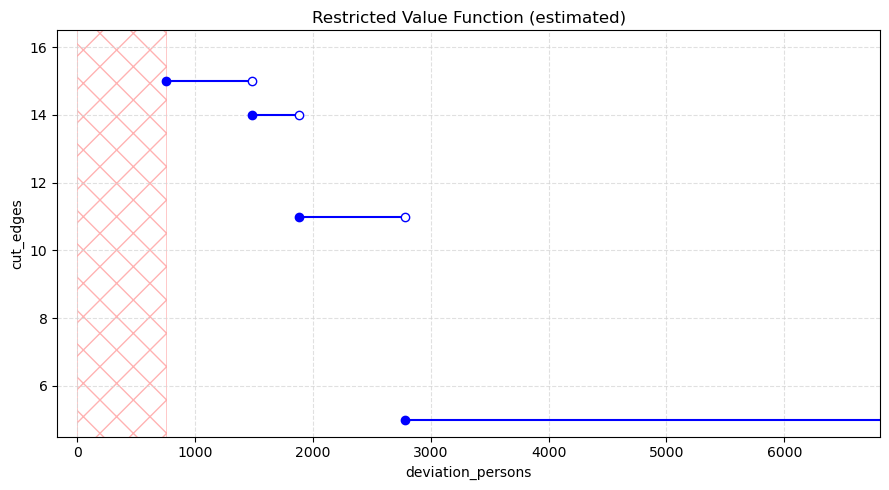

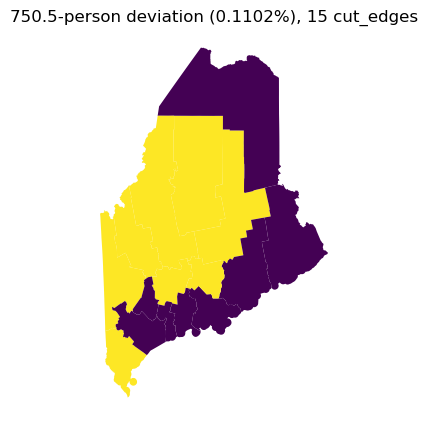

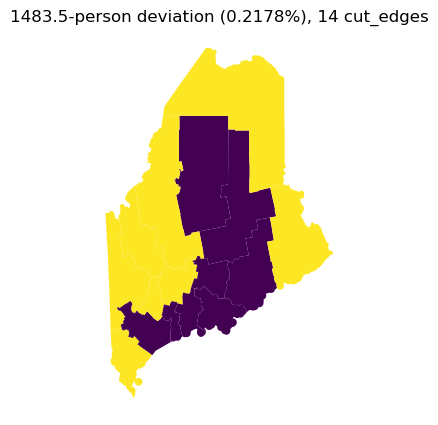

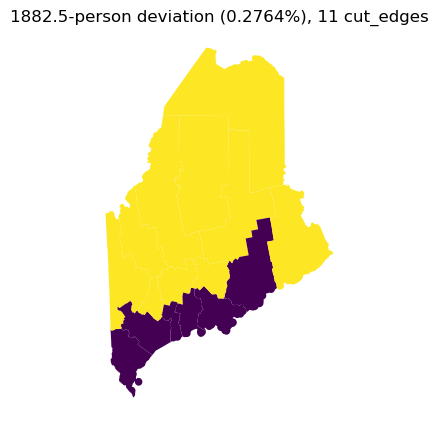

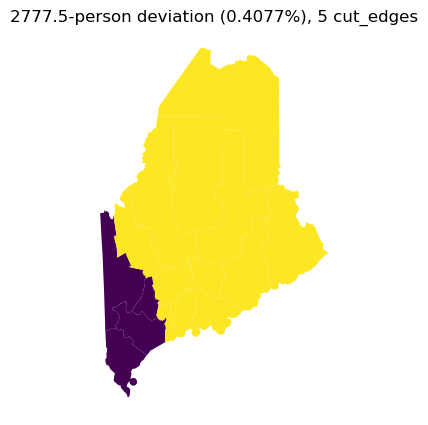

***************************************
obj_type = perimeter
***************************************
Pareto front objective values: [[750.5, 37.022377125354154], [1882.5, 30.979980713874923], [2777.5, 23.733763883955692]]


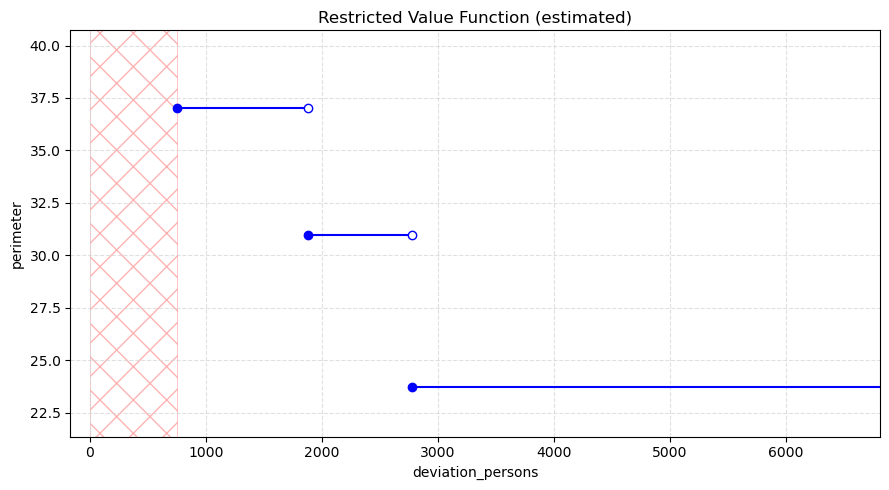

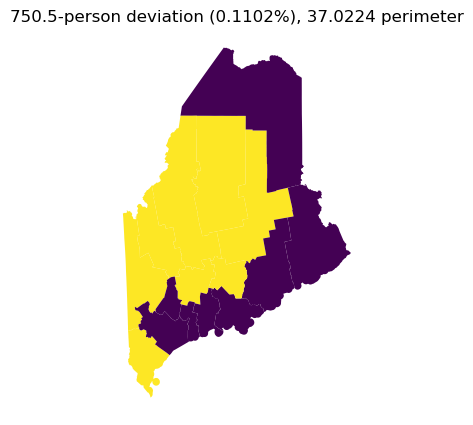

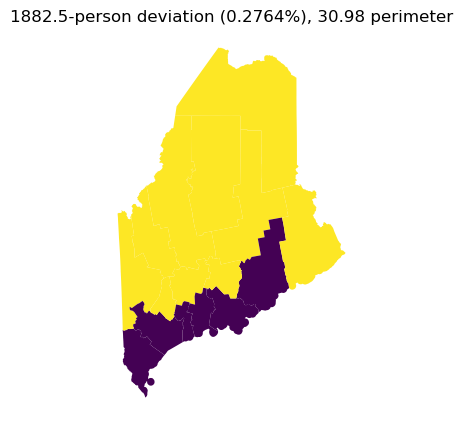

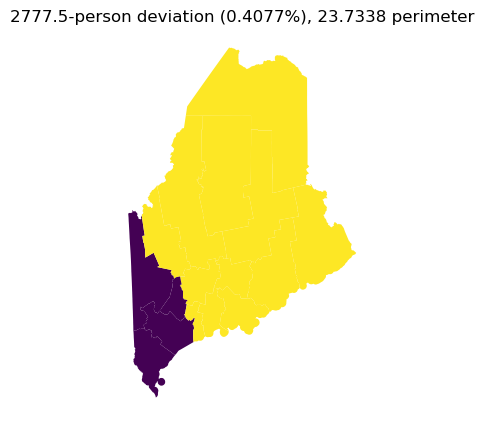

***************************************
obj_type = inverse_Polsby_Popper
***************************************
Pareto front objective values: [[750.5, 6.126891015162613], [1882.5, 5.047485703140486], [2777.5, 3.094050204160066]]


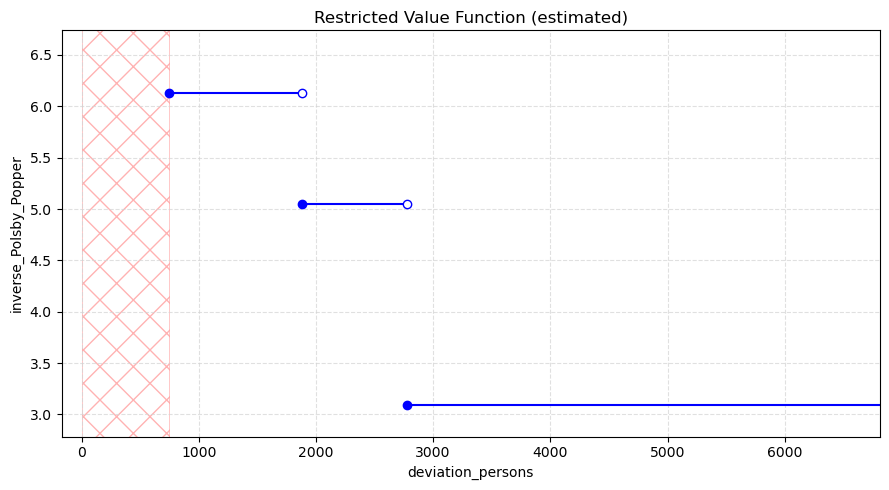

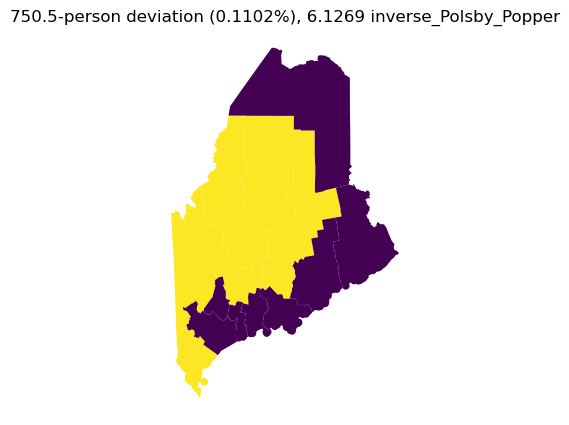

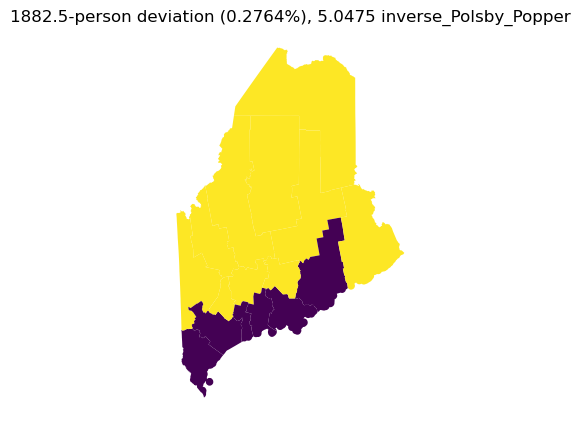

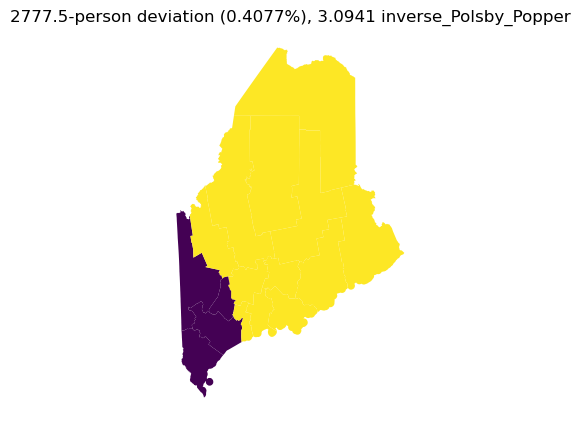

***************************************
obj_type = average_Polsby_Popper
***************************************
Pareto front objective values: [[750.5, 0.17519573386852202], [1882.5, 0.20765187988935258], [2777.5, 0.33204492607301983]]


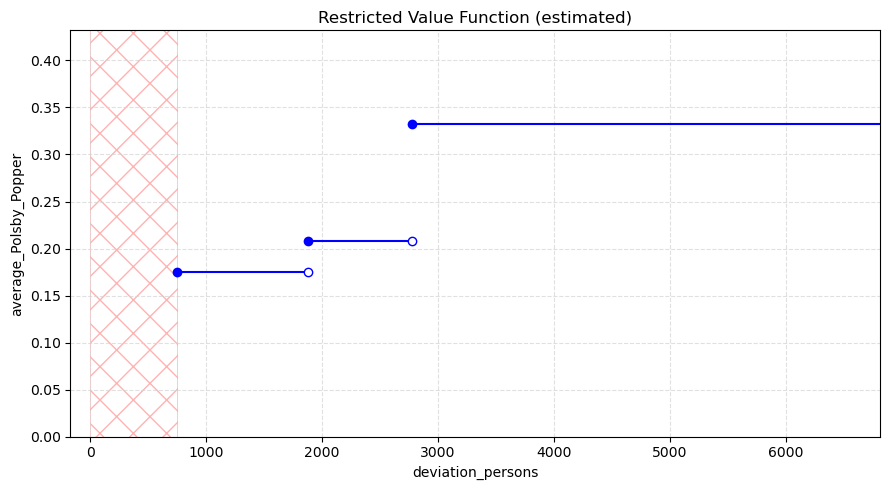

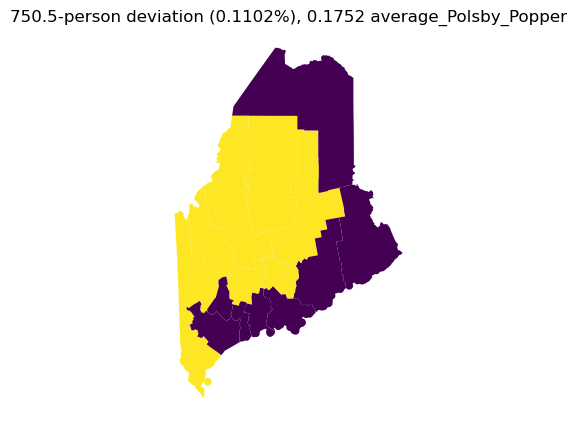

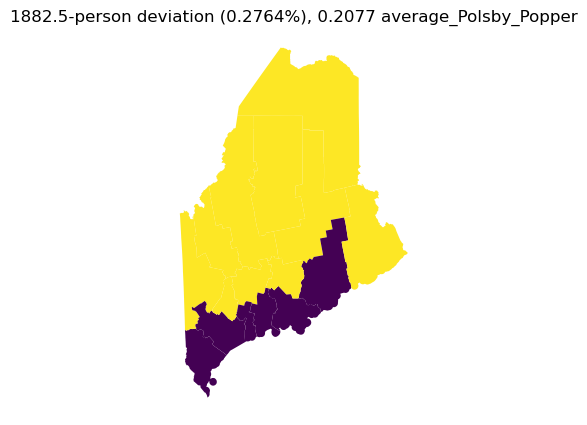

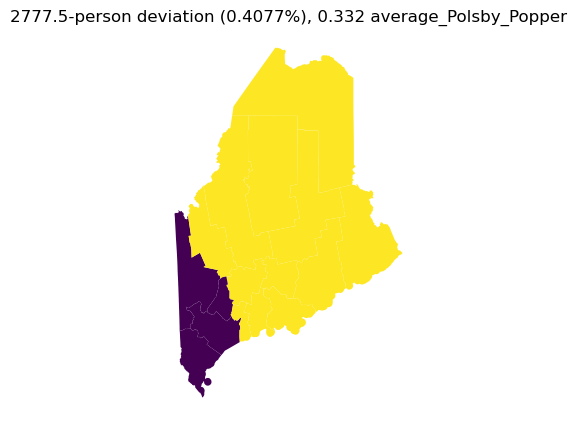

***************************************
obj_type = bottleneck_Polsby_Popper
***************************************
Pareto front objective values: [[750.5, 0.12938101738023425], [1882.5, 0.16315877430560258], [2777.5, 0.2778545795073467]]


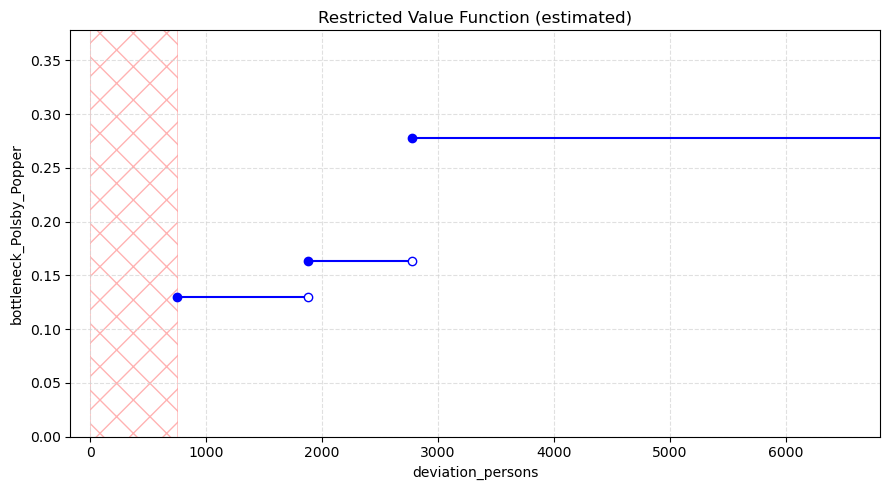

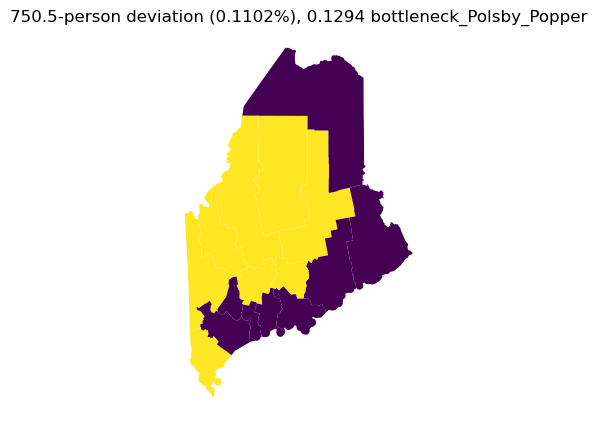

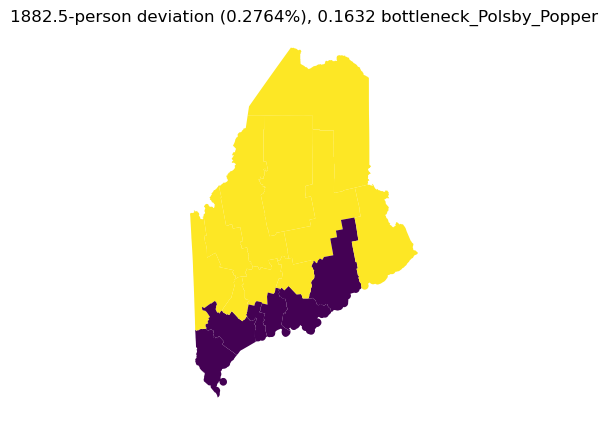

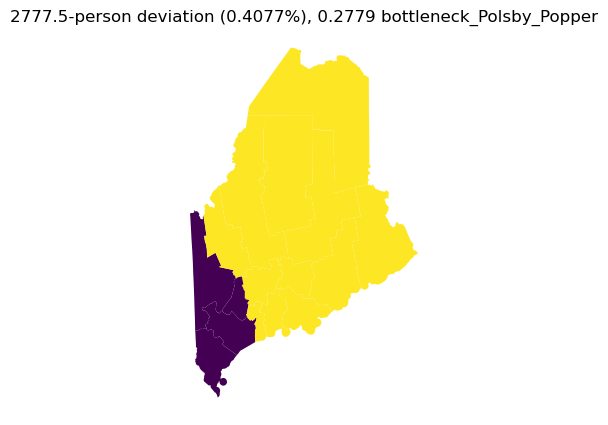

In [7]:
from pareto import plot_pareto_frontiers

obj_types = ['cut_edges', 'perimeter', 'inverse_Polsby_Popper', 'average_Polsby_Popper', 'bottleneck_Polsby_Popper']

pareto_plans = plot_pareto_frontiers(
                G,
                method='heuristic',
                plans=plans,                                   #if method ='epsilon_constraint_method' is None 
                obj_types=obj_types,                           #if method ='epsilon_constraint_method' is obj_type
                ideal_population=ideal_population,
                state=state,
                filepath=filepath,
                filename2=filename2,
                no_solution_region=no_solution_region,
                year=year,
                result=None,                                   #if method ='heuristic' is None 
             )

In [8]:
len(plans)

18

In [9]:
for obj_type in obj_types:
    print("***************************************")
    print("obj_type =", obj_type)
    print("***************************************")
    print("Pareto front plans:", pareto_plans[obj_type])

***************************************
obj_type = cut_edges
***************************************
Pareto front plans: [[[5, 6, 7, 8, 10, 12, 13, 14], [0, 1, 2, 3, 4, 9, 11, 15]], [[1, 4, 5, 6, 7, 8, 13, 15], [0, 2, 3, 9, 10, 11, 12, 14]], [[0, 5, 6, 7, 8, 13], [1, 2, 3, 4, 9, 10, 11, 12, 14, 15]], [[0, 3, 6, 12], [1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15]]]
***************************************
obj_type = perimeter
***************************************
Pareto front plans: [[[5, 6, 7, 8, 10, 12, 13, 14], [0, 1, 2, 3, 4, 9, 11, 15]], [[0, 5, 6, 7, 8, 13], [1, 2, 3, 4, 9, 10, 11, 12, 14, 15]], [[0, 3, 6, 12], [1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15]]]
***************************************
obj_type = inverse_Polsby_Popper
***************************************
Pareto front plans: [[[5, 6, 7, 8, 10, 12, 13, 14], [0, 1, 2, 3, 4, 9, 11, 15]], [[0, 5, 6, 7, 8, 13], [1, 2, 3, 4, 9, 10, 11, 12, 14, 15]], [[0, 3, 6, 12], [1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15]]]
**********************